<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [5]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!curl "https://drive.usercontent.google.com/download?id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF&confirm=xxx" -o hw2_data.zip
!unzip -qq hw2_data.zip -d deepul/homeworks/hw2/data
!pip install ./deepul
from deepul.hw2_helper import *

Cloning into 'deepul'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 254 (delta 46), reused 32 (delta 32), pack-reused 182
Receiving objects: 100% (254/254), 94.70 MiB | 6.26 MiB/s, done.
Resolving deltas: 100% (95/95), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  231M  100  231M    0     0  6324k      0  0:00:37  0:00:37 --:--:-- 5643k
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=22797 sha256=192f9a47a84f4b84cc5224f5d579d16b378a6173677f7ee52b8140d7bafd3c06
  Stored in directory: /tmp/pip-ephem-wheel-cache-r6s4jny_/wheels/61/44/55/90ee477fb305b60644546ed2b93c75d1574650192b9a6d82e1
Successfully built deepul
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
  

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


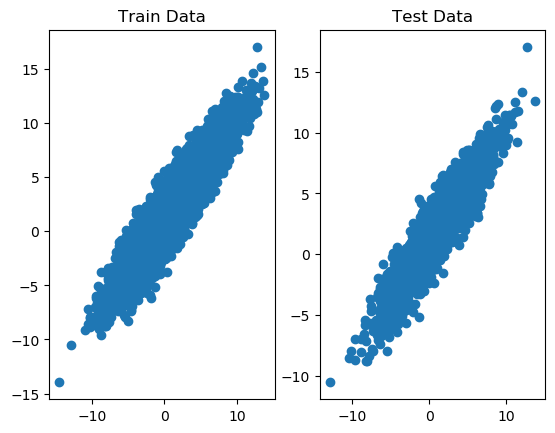

Dataset 2


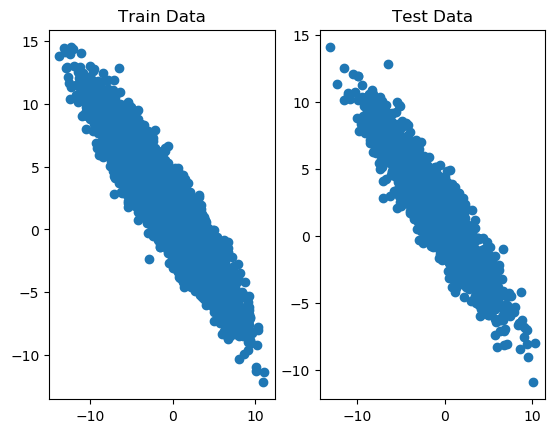

In [2]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [16]:

from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim


def train(model, train_loader, optimizer, epoch, quiet, grad_clip=None):
    model.train()

    if not quiet:
        pbar = tqdm(total=len(train_loader.dataset))
    losses = OrderedDict()
    for x in train_loader:
        x = x.cuda()
        out = model.loss(x)
        optimizer.zero_grad()
        out['loss'].backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        desc = f'Epoch {epoch}'
        for k, v in out.items():
            if k not in losses:
                losses[k] = []
            losses[k].append(v.item())
            avg_loss = np.mean(losses[k][-50:])
            desc += f', {k} {avg_loss:.4f}'

        if not quiet:
            pbar.set_description(desc)
            pbar.update(x.shape[0])
    if not quiet:
        pbar.close()
    return losses


def eval_loss(model, data_loader, quiet):
    model.eval()
    total_losses = OrderedDict()
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda()
            out = model.loss(x)
            for k, v in out.items():
                total_losses[k] = total_losses.get(k, 0) + v.item() * x.shape[0]

        desc = 'Test '
        for k in total_losses.keys():
            total_losses[k] /= len(data_loader.dataset)
            desc += f', {k} {total_losses[k]:.4f}'
        if not quiet:
            print(desc)
    return total_losses


def train_epochs(model, train_loader, test_loader, train_args, quiet=False):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = OrderedDict(), OrderedDict()
    for epoch in range(epochs):
        model.train()
        train_loss = train(model, train_loader, optimizer, epoch, quiet, grad_clip)
        test_loss = eval_loss(model, test_loader, quiet)

        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
                test_losses[k] = []
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return train_losses, test_losses


class MLP(nn.Module):
    def __init__(self, input_shape, output_shape, hiddens=[]):
        super().__init__()

        if isinstance(input_shape, int):
            input_shape = (input_shape,)
        if isinstance(output_shape, int):
            output_shape = (output_shape,)

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hiddens = hiddens

        model = []
        prev_h = np.prod(input_shape)
        for h in hiddens + [np.prod(output_shape)]:
            model.append(nn.Linear(prev_h, h))
            model.append(nn.ReLU())
            prev_h = h
        model.pop()
        self.net = nn.Sequential(*model)

    def forward(self, x):
        b = x.shape[0]
        x = x.view(b, -1)
        return self.net(x).view(b, *self.output_shape)


class FullyConnectedVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, enc_hidden_sizes=[],
                 dec_hidden_sizes=[]):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = MLP(input_dim, 2 * latent_dim, enc_hidden_sizes)
        self.decoder = MLP(latent_dim, 2 * input_dim, dec_hidden_sizes)

    def loss(self, x):
        mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)
        z = torch.randn_like(mu_z) * log_std_z.exp() + mu_z
        mu_x, log_std_x = self.decoder(z).chunk(2, dim=1)

        # Compute reconstruction loss - Note that it may be easier for you
        # to use torch.distributions.normal to compute the log_prob
        recon_loss = 0.5 * np.log(2 * np.pi) + log_std_x + \
                     (x - mu_x) ** 2 * torch.exp(-2 * log_std_x) * 0.5
        recon_loss = recon_loss.sum(1).mean()

        # Compute KL
        kl_loss = -log_std_z - 0.5 + (torch.exp(2 * log_std_z) + mu_z ** 2) * 0.5
        kl_loss = kl_loss.sum(1).mean()

        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n, noise=True):
        with torch.no_grad():
            z = torch.randn(n, self.latent_dim).cuda()
            mu, log_std = self.decoder(z).chunk(2, dim=1)
            if noise:
                z = torch.randn_like(mu) * log_std.exp() + mu
            else:
                z = mu
        return z.cpu().numpy()
     

def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    model = FullyConnectedVAE(2, 2, [128, 128], [128, 128]).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                             dict(epochs=10, lr=1e-3), quiet=True)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)

    samples_noise = model.sample(1000, noise=True)
    samples_nonoise = model.sample(1000, noise=False)

    return train_losses, test_losses, samples_noise, samples_nonoise

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Final -ELBO: 4.4361, Recon Loss: 2.8577, KL Loss: 1.5784


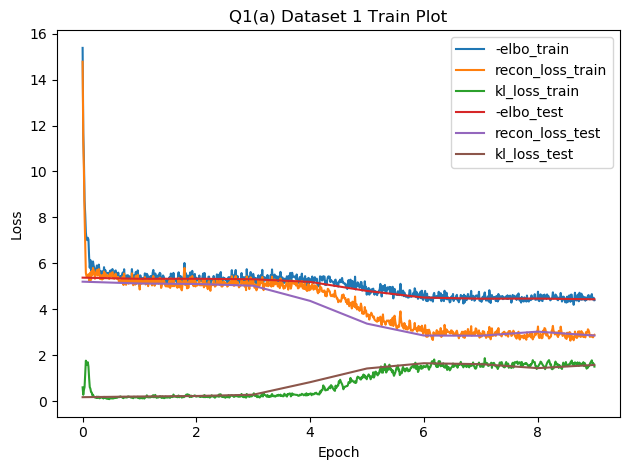

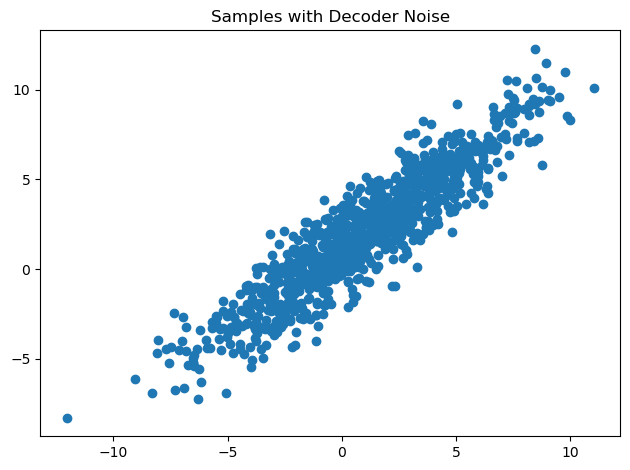

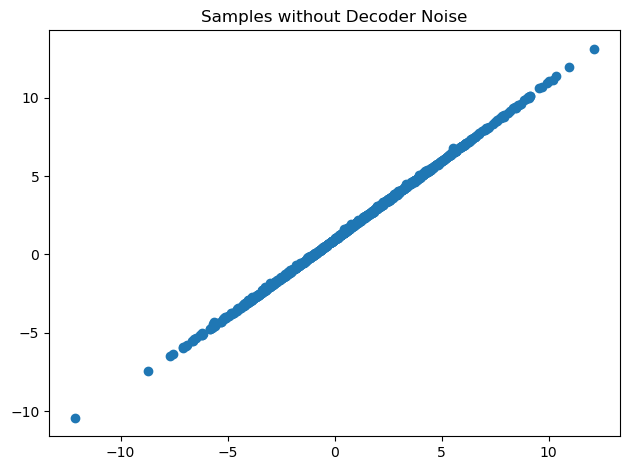

In [17]:
q1_save_results('a', 1, q1)

Final -ELBO: 4.4646, Recon Loss: 2.9210, KL Loss: 1.5436


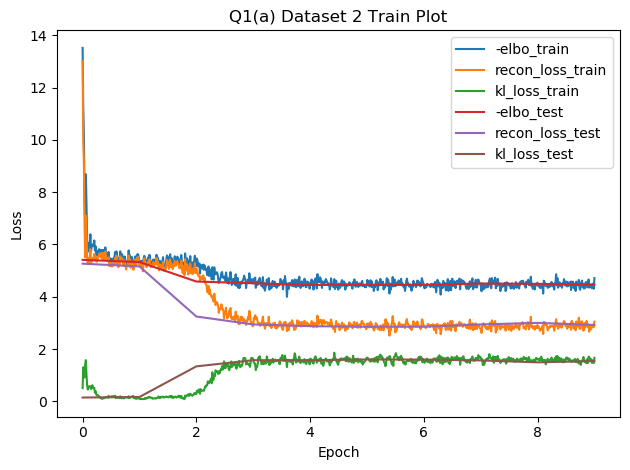

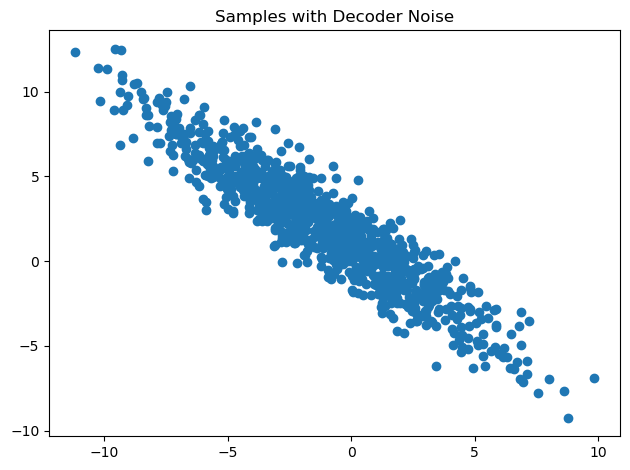

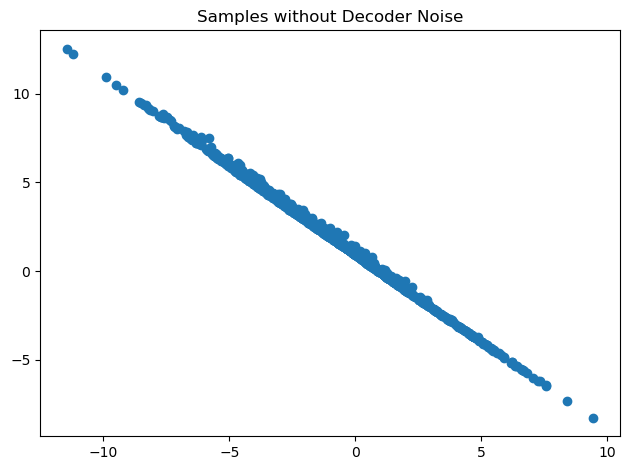

In [18]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


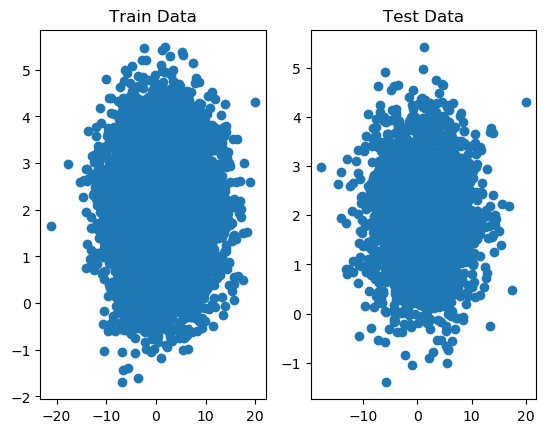

Dataset 2


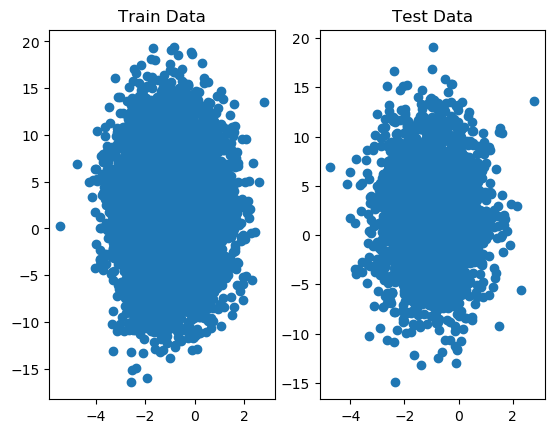

In [19]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

Final -ELBO: 4.4219, Recon Loss: 4.4123, KL Loss: 0.0095


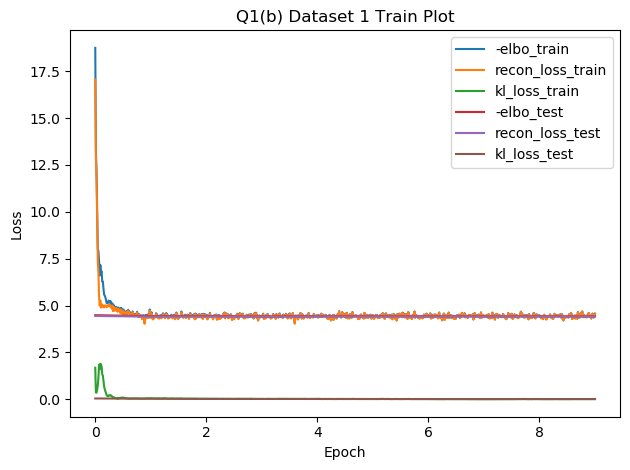

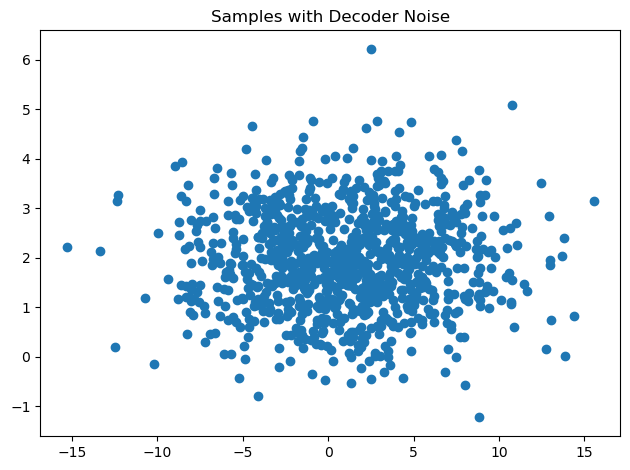

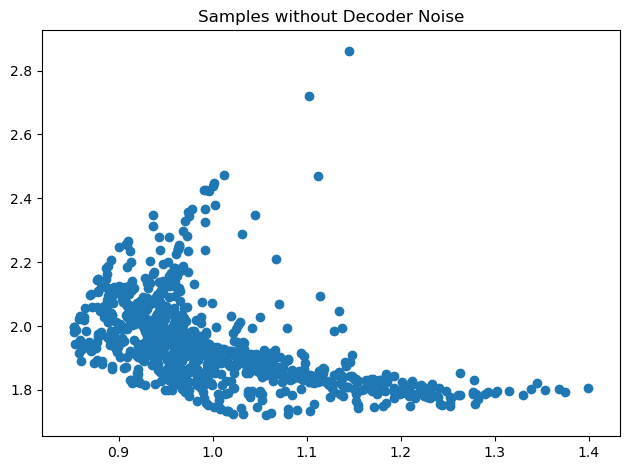

In [20]:
q1_save_results('b', 1, q1)

Final -ELBO: 4.4292, Recon Loss: 4.4253, KL Loss: 0.0039


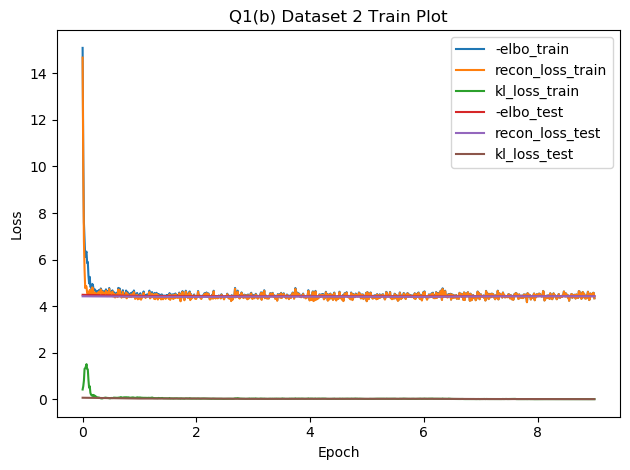

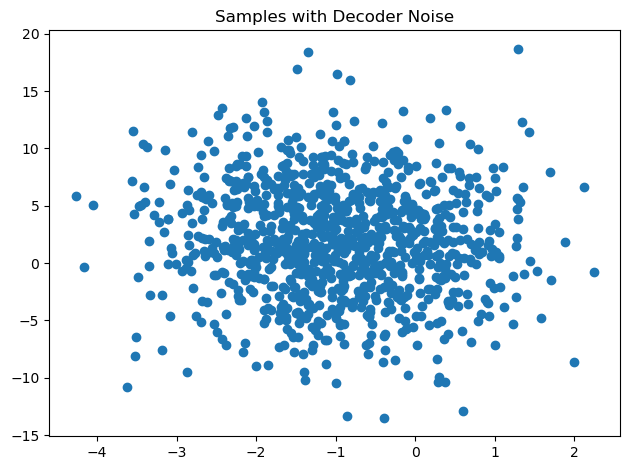

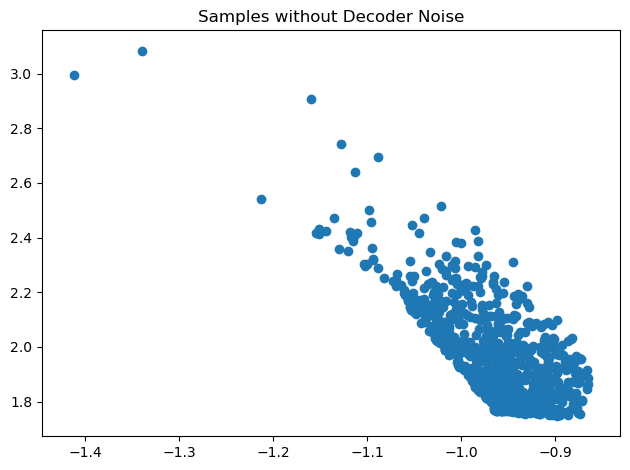

In [21]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

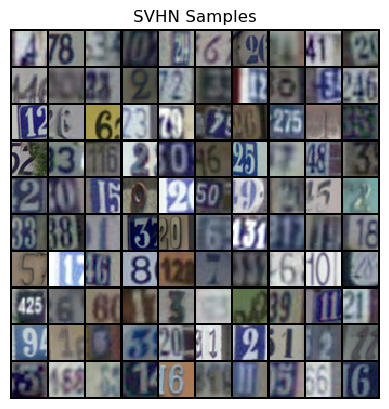

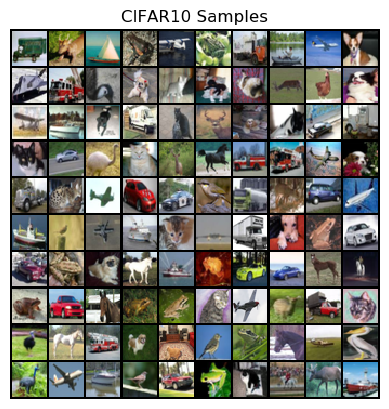

In [26]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [35]:
import torch
from deepul.hw2_helper import *
from torch.distributions.normal import Normal as Normal
class VAE(torch.nn.Module):

    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.sample_num = 2
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Define the encoder whose distribution is q(z|x)
        self.encoder_conv = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 3, 2, 1), # 16 x 16
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, 3, 2, 1), # 8 x 8
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 256, 3, 2, 1), # 4 x 4
            torch.nn.ReLU())
        self.encoder_linear = torch.nn.Linear(4 * 4 * 256, 2 * self.latent_dim)

        # Define the decoder whose distribution is p(x|z)
        self.decoder_linear = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, 4 * 4 * 128),
            torch.nn.ReLU())

        self.decoder_conv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 128, 4, 2, 1), # 8 x 8
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, 1), # 16 x 16
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, 4, 2, 1), # 32 x 32
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 3, 3, 1, 1))

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.permute(0, 3, 1, 2).to(self.device).float()
        outs = self.encoder_conv(x)
        outs = outs.reshape(batch_size, -1)
        u_z, log_sigma_z = torch.chunk(self.encoder_linear(outs), 2, dim=-1)
        u_z = u_z.unsqueeze(1).repeat(1, self.sample_num, 1)
        sigma_z = torch.exp(log_sigma_z).unsqueeze(1).repeat(1, self.sample_num, 1)
        epsilon = torch.normal(0, 1, size=(batch_size, self.sample_num, self.latent_dim)).to(self.device)
        z_samples = u_z + epsilon * sigma_z

        z_samples = z_samples.view(size=(-1, self.latent_dim))
        z_outs = self.decoder_linear(z_samples)
        z_outs = z_outs.view(size=(batch_size * self.sample_num, 128, 4, 4))
        z_outs = self.decoder_conv(z_outs)
        z_outs = z_outs.view(batch_size, self.sample_num, 3, 32, 32)
        log_p_theta = Normal(z_outs, 1).log_prob(x.unsqueeze(1).repeat(1, self.sample_num, 1, 1, 1))
        log_p_z = Normal(0, 1).log_prob(z_samples).view(batch_size, self.sample_num, -1)
        log_q_phi = Normal(u_z, sigma_z).log_prob(z_samples.view(size=u_z.shape))
        mse_loss = (z_outs - x.unsqueeze(1).repeat(1, self.sample_num, 1, 1, 1)) ** 2

        return log_p_theta.sum(dim=[2, 3, 4]), log_p_z.sum(dim=[2]), log_q_phi.sum(dim=[2]), mse_loss.sum(dim=[2, 3, 4]), z_outs

    def loss(self, x):
        losses = self(x)
        elbo = torch.mean(losses[2] - losses[1] + losses[3])
        reconstruction_loss = torch.mean(losses[3])
        kl_loss = torch.mean(losses[2] - losses[1])
        return elbo, reconstruction_loss, kl_loss

    def sample_pairs(self, x):
        pre_sample_num = self.sample_num
        self.sample_num = 1
        x = torch.from_numpy(x).to(self.device).float()
        with torch.no_grad():
            results = self(x)
            z_outs = torch.squeeze(results[-1])
            reconstructed_images = z_outs
        self.sample_num = pre_sample_num
        image_list = []
        for i in range(x.shape[0]):
            image_list.extend([x[i], reconstructed_images[i].permute(1, 2, 0)])
        return torch.stack(image_list, dim=0).cpu().data.numpy()

    def interpolation(self, x):
        batch_size = x.shape[0]
        x = torch.from_numpy(x)
        x = x.permute(0, 3, 1, 2).to(self.device).float()
        outs = self.encoder_conv(x)
        outs = torch.reshape(outs, (batch_size, -1))#change
        u_z, _ = torch.chunk(self.encoder_linear(outs), 2, dim=-1)

        image_list = []
        lamda = [(i + 1) / 9 for i in range(8)]
        for i in range(10):
            image_list.append(x[2 * i].permute(1, 2, 0))
            for coeff in lamda:
                z_samples = (1 - coeff) * u_z[2 * i] + coeff * u_z[2 * i + 1]
                z_outs = self.decoder_linear(z_samples)
                z_outs = z_outs.view(size=(1, 128, 4, 4))
                z_outs = self.decoder_conv(z_outs)
                z_outs = z_outs.view(1, 3, 32, 32)
                image_list.append(z_outs[0].permute(1, 2, 0))
            image_list.append(x[2 * i + 1].permute(1, 2, 0))
        return torch.stack(image_list, dim=0).cpu().data.numpy()

    def sample(self, num_samples):
        with torch.no_grad():
            z_samples = torch.normal(0, 1, size=(num_samples, self.latent_dim)).to(self.device)
            z_outs = self.decoder_linear(z_samples)
            z_outs = z_outs.view(size=(num_samples, 128, 4, 4))
            z_outs = self.decoder_conv(z_outs)
            return z_outs.permute(0, 2, 3, 1).cpu().data.numpy()

def fit(data_loader, model, optimizer, epochs):
    train_losses = []
    epoch_losses = []
    result = 0.
    for epoch in range(epochs):

        elbo, reconstruction_loss, kl_loss = 0., 0., 0.

        for i, batch in enumerate(data_loader):
            optimizer.zero_grad()
            result = model.loss(batch)
            loss = result[0]
            loss.backward()
            optimizer.step()

            elbo = (elbo + (loss.cpu().item() * batch.shape[0])) / len(batch)
            reconstruction_loss = (reconstruction_loss + (result[1].cpu().item() * batch.shape[0])) / len(batch)
            kl_loss = (kl_loss + (result[2].cpu().item() * batch.shape[0])) / len(batch)
            metrics = [elbo, reconstruction_loss, kl_loss]
            train_losses.append(metrics)

        print("epoch:", epoch, ",elbo:",elbo,",reconn_loss:",reconstruction_loss,",kl loss:",kl_loss)

        assert(type(elbo) == float)
        assert(type(reconstruction_loss) == float)
        assert(type(kl_loss) == float)


        epoch_losses.append(metrics)

        # Record per epoch statistics

    print("epoch_losses length: ", len(epoch_losses))
    return  np.array(train_losses, dtype=np.float32), np.array(epoch_losses, dtype=np.float32)
    
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    latent_dim = 16
    batch_size = 128
    lr = .001
    epochs = 10
    img_input_shape = (32,32,3)
    num_samples = 100
    num_reconstructions = 50
    num_interpolations = 100

    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

    # Normalize pixel values to be between 0,1
    train_data = (train_data / 255 - 0.5) * 2
    test_data = (test_data / 255 - 0.5) * 2

    # Load dataset
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    assert(np.ndim(train_loader.dataset) == 4)
    assert(np.ndim(train_data) == 4)

    # Initialize the model
    vae = VAE(latent_dim).to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
    print(vae)

    # Run training loop
    test_losses, epoch_losses = fit(train_loader, vae, optimizer, epochs)

    # Generate samples
    samples = (vae.sample(num_samples) + 1) * 255 / 2
    assert(samples.shape == (100, 32, 32, 3))

    # Generate real image/reconstructed pairs
    reconstructed_pairs = train_data[0:num_reconstructions]
    reconstructed_pairs = (vae.sample_pairs(reconstructed_pairs) + 1) * 255 / 2
    assert(reconstructed_pairs.shape == (100, 32, 32, 3))

    # Generate interpolations
    interpolations = train_data[0:num_interpolations]
    interpolations = (vae.interpolation(interpolations) + 1) * 255 / 2
    assert(interpolations.shape == (100, 32, 32, 3))

    return test_losses, epoch_losses, samples, reconstructed_pairs, interpolations

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

VAE(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (encoder_linear): Linear(in_features=4096, out_features=32, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=16, out_features=2048, bias=True)
    (1): ReLU()
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=

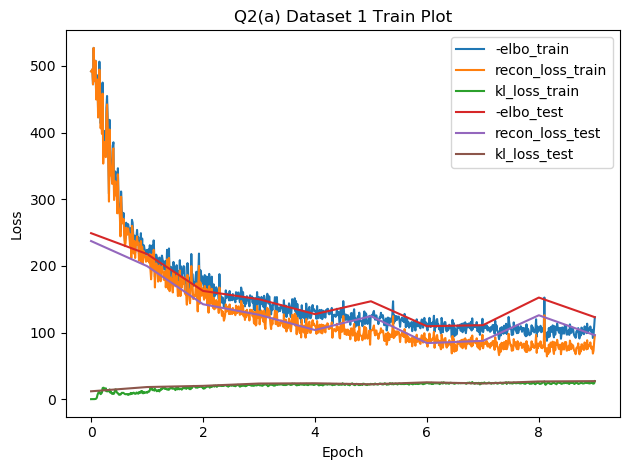

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


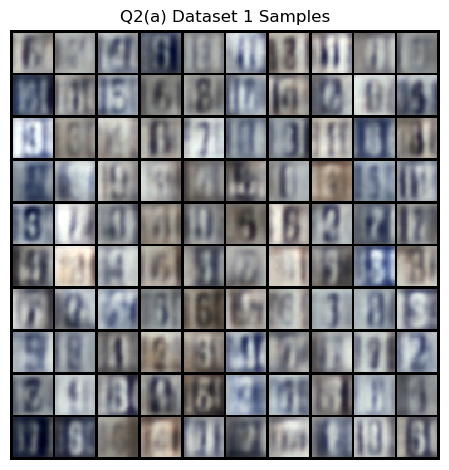

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


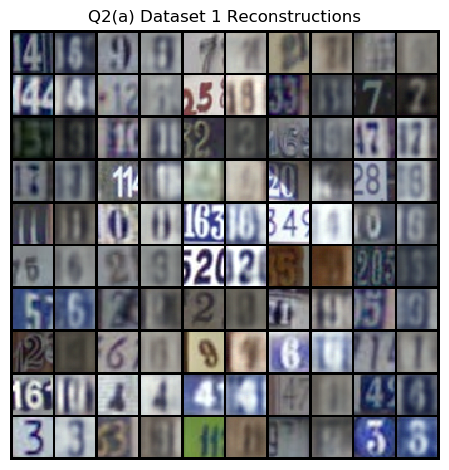

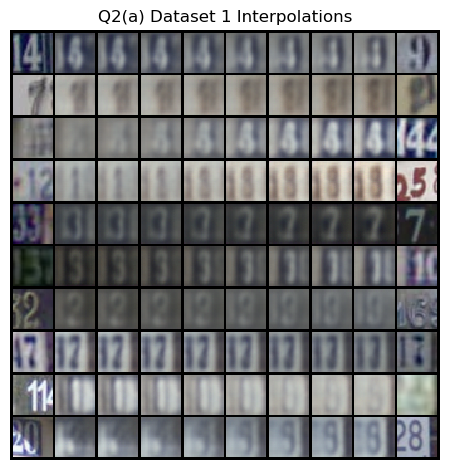

In [36]:
q2_save_results('a', 1, q2_a)

VAE(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (encoder_linear): Linear(in_features=4096, out_features=32, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=16, out_features=2048, bias=True)
    (1): ReLU()
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=

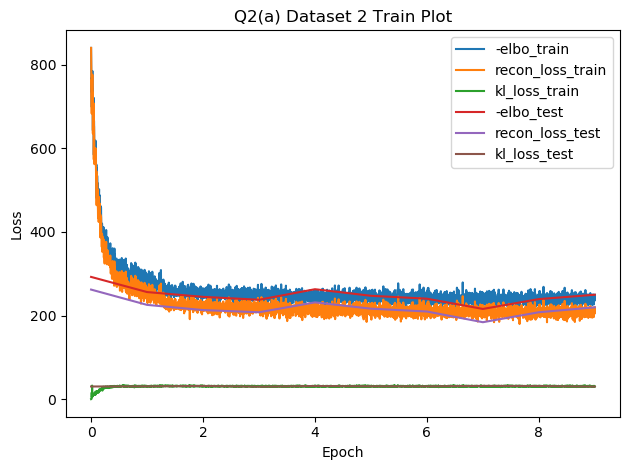

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


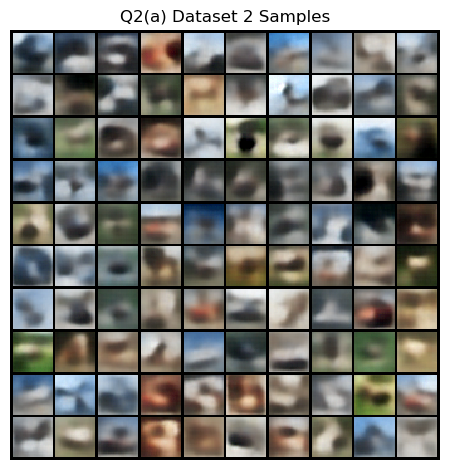

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


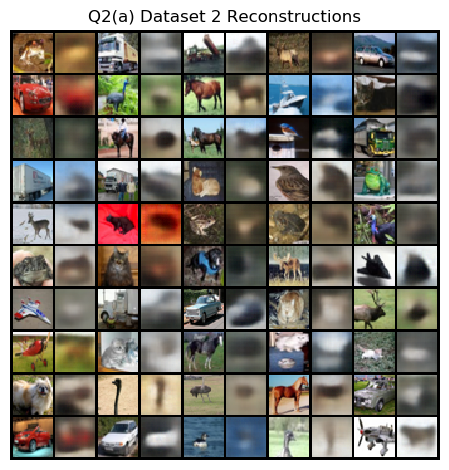

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


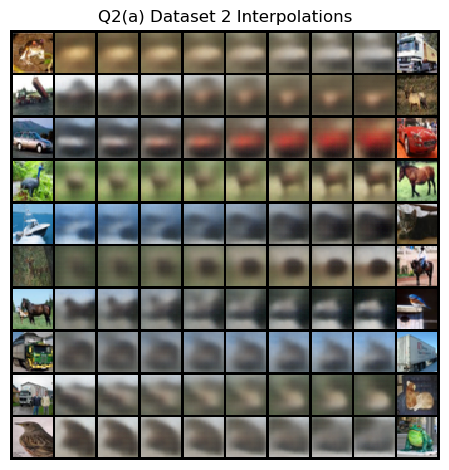

In [37]:
q2_save_results('a', 2, q2_a)

## Part (b) Hierarchical VAE [20pts]

In this part, we will explore a simplified version of the hierarchical VAE described in [NVAE](https://arxiv.org/pdf/2007.03898.pdf). We will not implement the full NVAE, but rather use some ideas from the paper to explore how to learn a prior distribution p(z).

Implement a hierarchical VAE that follows the following structure.
* $z1$ is a 2x2x12 latent vector where p(z1) is the unit Gaussian.
    * Learn the approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix. I.e., same as a normal VAE, but use a matrix latent rather than a vector. Each dimension is independent.
* $z2$ is a 2x2x12 latent vector.
    * $p_\theta(z2|z1)$ is learned, and implemented as a neural network that parameterizes mean (and log std, optionally).
    * $q_\theta(z2|z1,x)$ is also learned. Implement this as a Residual Normal [see NVAE] over the prior $p_\theta(z2|z1)$.
* The decoder should be a function of $z2$ only.

Some helpful hints:
* Two KL losses should be calculated. The first should match $q_\theta(z|x)$ to the unit Gaussian. The second should match $q_\theta(z2|z1,x)$ and $p_\theta(z2|z1)$, and be taken with respect to $q$.
* When calculating the second KL term, utilize the analytic form for the residual normal. When $q_\theta(z2|z1,x) = N(z2; \mu_\theta(z1) + \Delta \mu_\theta(z1,x), \Sigma_\theta(z1)) * \Delta \Sigma_\theta(z1,x))$, use the following form: `kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5`
* When calculating KL, remember to sum over the dimensions of the latent variable before taking the mean over batch.
* For the prior $p_\theta(z2|z1)$, fix standard deviation to be 1. Learn only the mean. This will help with stability in training.

The following network structures may be useful:
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
        nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
        LayerNorm(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
We assume encoder networks are of the form p(z'|z,x).
When learning q(z1), an x of all zeros can be used as input.
Upscale z with nearest-neighbor projection before concatenating with x.


Decoder
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
```


**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [39]:
class MaskedLinear(torch.nn.Linear):
    """ same as Linear except has a configurable mask on the weights """

    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(mask)

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

class Made(torch.nn.Module):
    def __init__(self, masked_matrix_list, hidden_units):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.register_parameter("shift", torch.nn.Parameter(torch.ones(size=(1, hidden_units[-1] // 2)), requires_grad=True))
        self.register_parameter("scale", torch.nn.Parameter(torch.ones(size=(1, hidden_units[-1] // 2)), requires_grad=True))
        self.fc1 = MaskedLinear(hidden_units[0], hidden_units[1])
        self.fc1.set_mask(masked_matrix_list[0])
        self.fc2 = MaskedLinear(hidden_units[1], hidden_units[2])
        self.fc2.set_mask(masked_matrix_list[1])
        self.fc3 = MaskedLinear(hidden_units[2], hidden_units[3])
        self.fc3.set_mask(masked_matrix_list[2])
        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()
        self.masked_matrix_list = masked_matrix_list
        self.latent_dim = hidden_units[-1] // 2

    def forward(self, inputs):
        inputs = inputs.to(self.device)
        outs = self.relu(self.fc1(inputs))
        outs = self.relu(self.fc2(outs))
        log_s, t = torch.chunk(self.relu(self.fc3(outs)), chunks=2, dim=-1)
        log_s = self.scale * self.tanh(log_s) + self.shift
        epsilon = inputs * torch.exp(log_s) + t
        log_p_epsilon = Normal(0, 1).log_prob(epsilon)
        log_det = log_s
        return log_p_epsilon + log_det

    def sample(self, sample_num):
        z = torch.normal(0, 1, size=(sample_num, self.latent_dim))
        x = torch.zeros(size=z.shape)
        for _ in range(self.latent_dim):
            x = self.inverse(z, x)
        return x

    def inverse(self, z, x):
        z = z.to(self.device)
        x = x.to(self.device)
        outs = self.relu(self.fc1(x))
        outs = self.relu(self.fc2(outs))
        log_s, t = torch.chunk(self.relu(self.fc3(outs)), chunks=2, dim=-1)
        log_s = self.scale * self.tanh(log_s) + self.shift
        x = (z - t) / torch.exp(log_s)
        return x

class ImageVAEAFPrior(torch.nn.Module):
    def __init__(self, sample_num, latent_dim):
        super().__init__()
        self.sample_num = sample_num
        self.latent_dim = latent_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder_conv = torch.nn.Sequential(torch.nn.Conv2d(3, 32, 3, 1, 1),
                                          torch.nn.ReLU(),
                                          torch.nn.Conv2d(32, 64, 3, 2, 1),
                                          torch.nn.ReLU(),
                                          torch.nn.Conv2d(64, 128, 3, 2, 1),
                                          torch.nn.ReLU(),
                                          torch.nn.Conv2d(128, 256, 3, 2, 1),
                                          torch.nn.ReLU())
        self.encoder_linear = torch.nn.Linear(4 * 4 * 256, 2 * self.latent_dim)
        self.decoder_linear = torch.nn.Sequential(torch.nn.Linear(self.latent_dim, 4 * 4 * 128), torch.nn.ReLU())
        self.decoder_conv = torch.nn.Sequential(torch.nn.ConvTranspose2d(128, 128, 4, 2, 1),
                                          torch.nn.ReLU(),
                                          torch.nn.ConvTranspose2d(128, 64, 4, 2, 1),
                                          torch.nn.ReLU(),
                                          torch.nn.ConvTranspose2d(64, 32, 4, 2, 1),
                                          torch.nn.ReLU(),
                                          torch.nn.Conv2d(32, 3, 3, 1, 1), torch.nn.Tanh())
        hidden_units = [latent_dim, 256, 256, 2 * latent_dim]
        m0 = np.array([i + 1 for i in range(latent_dim)], dtype=np.int8)
        m1 = np.random.randint(low=1, high=latent_dim, size=hidden_units[1])
        m2 = np.random.randint(low=1, high=latent_dim, size=hidden_units[2])
        m3 = np.array([i + 1 for i in range(latent_dim)] * 2, dtype=np.int8)
        M1 = torch.from_numpy(m1[np.newaxis].transpose() >= m0[np.newaxis])
        M2 = torch.from_numpy(m2[np.newaxis].transpose() >= m1[np.newaxis])
        M3 = torch.from_numpy(m3[np.newaxis].transpose() > m2[np.newaxis])
        self.af_flow = Made([M1, M2, M3], hidden_units)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.permute(0, 3, 1, 2).to(self.device).float()
        outs = self.encoder_conv(x)
        outs = torch.reshape(outs, (batch_size, -1))
        u_z, log_sigma_z = torch.chunk(self.encoder_linear(outs), 2, dim=-1)
        u_z = u_z.unsqueeze(1).repeat(1, self.sample_num, 1)
        sigma_z = torch.exp(log_sigma_z).unsqueeze(1).repeat(1, self.sample_num, 1)
        epsilon = torch.normal(0, 1, size=(batch_size, self.sample_num, self.latent_dim)).to(self.device)
        z_samples = u_z + epsilon * sigma_z

        z_samples = z_samples.view(size=(-1, self.latent_dim))
        z_outs = self.decoder_linear(z_samples)
        z_outs = z_outs.view(size=(batch_size * self.sample_num, 128, 4, 4))
        z_outs = self.decoder_conv(z_outs)
        z_outs = z_outs.view(batch_size, self.sample_num, 3, 32, 32)
        log_p_theta = Normal(z_outs, 1).log_prob(x.unsqueeze(1).repeat(1, self.sample_num, 1, 1, 1))
        log_p_z = self.af_flow.forward(z_samples).view(batch_size, self.sample_num, -1)
        log_q_phi = Normal(u_z, sigma_z).log_prob(z_samples.view(size=u_z.shape))
        mse_loss = (z_outs - x.unsqueeze(1).repeat(1, self.sample_num, 1, 1, 1)) ** 2

        return log_p_theta.sum(dim=[2, 3, 4]), log_p_z.sum(dim=[2]), log_q_phi.sum(dim=[2]), mse_loss.sum(dim=[2, 3, 4]), z_outs

    def loss(self, x):
        losses = self(x)
        elbo = torch.mean(losses[2] - losses[1] + losses[3])
        reconstruction_loss = torch.mean(losses[3])
        kl_loss = torch.mean(losses[2] - losses[1])
        return elbo, reconstruction_loss, kl_loss

    def sample(self, num_samples):
        with torch.no_grad():
            z_samples = self.af_flow.sample(num_samples).to(self.device)
            z_outs = self.decoder_linear(z_samples)
            z_outs = z_outs.view(size=(100, 128, 4, 4))
            z_outs = self.decoder_conv(z_outs)
            return z_outs.permute(0, 2, 3, 1).cpu().data.numpy()

    def sample_pairs(self, x):
        pre_sample_num = self.sample_num
        self.sample_num = 1
        x = torch.from_numpy(x).to(self.device).float()
        with torch.no_grad():
            results = self(x)
            z_outs = torch.squeeze(results[-1])
            reconstructed_images = z_outs
        self.sample_num = pre_sample_num
        image_list = []
        for i in range(x.shape[0]):
            image_list.extend([x[i], reconstructed_images[i].permute(1, 2, 0)])
        return torch.stack(image_list, dim=0).cpu().data.numpy()

    def interpolation(self, x):
        batch_size = x.shape[0]
        x = torch.from_numpy(x)
        x = x.permute(0, 3, 1, 2).to(self.device).float()
        outs = self.encoder_conv(x)
        outs = torch.reshape(outs, (batch_size, -1))
        u_z, _ = torch.chunk(self.encoder_linear(outs), 2, dim=-1)

        image_list = []
        lamda = [(i + 1) / 9 for i in range(8)]
        for i in range(10):
            image_list.append(x[2 * i].permute(1, 2, 0))
            for coeff in lamda:
                z_samples = (1 - coeff) * u_z[2 * i] + coeff * u_z[2 * i + 1]
                z_outs = self.decoder_linear(z_samples)
                z_outs = z_outs.view(size=(1, 128, 4, 4))
                z_outs = self.decoder_conv(z_outs)
                z_outs = z_outs.view(1, 3, 32, 32)
                image_list.append(z_outs[0].permute(1, 2, 0))
            image_list.append(x[2 * i + 1].permute(1, 2, 0))
        return torch.stack(image_list, dim=0).cpu().data.numpy()
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    latent_dim = 16
    batch_size = 128
    lr = .001
    epochs = 10
    num_samples = 100
    num_reconstructions = 50
    num_interpolations = 100

    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

    # Normalize pixel values to be between 0,1
    train_data = (train_data / 255 - 0.5) * 2
    test_data = (test_data / 255 - 0.5) * 2

    # Load dataset
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    assert(np.ndim(train_loader.dataset) == 4)
    assert(np.ndim(train_data) == 4)

    # Initialize the model
    model = ImageVAEAFPrior(2, latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(model)

    # Run training loop
    train_losses, test_losses = fit(train_loader, model, optimizer, epochs)

    # Generate samples
    samples = (model.sample(num_samples) + 1) * 255 / 2
    assert(samples.shape == (100, 32, 32, 3))

    # Generate real image/reconstructed pairs
    reconstructed_pairs = train_data[0:num_reconstructions]
    reconstructed_pairs = (model.sample_pairs(reconstructed_pairs) + 1) * 255 / 2
    assert(reconstructed_pairs.shape == (100, 32, 32, 3))

    # Generate interpolations
    interpolations = train_data[0:num_interpolations]
    interpolations = (model.interpolation(interpolations) + 1) * 255 / 2
    assert(interpolations.shape == (100, 32, 32, 3))

    return train_losses, test_losses, samples, reconstructed_pairs, interpolations

import torch
import torch.nn
import torch.nn.functional as F

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

ImageVAEAFPrior(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (encoder_linear): Linear(in_features=4096, out_features=32, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=16, out_features=2048, bias=True)
    (1): ReLU()
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), paddi

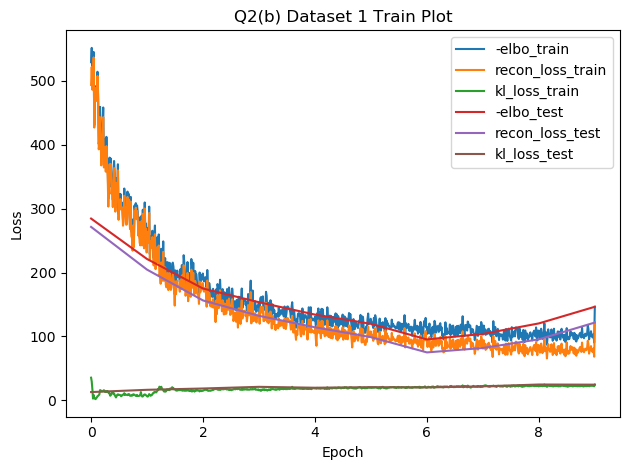

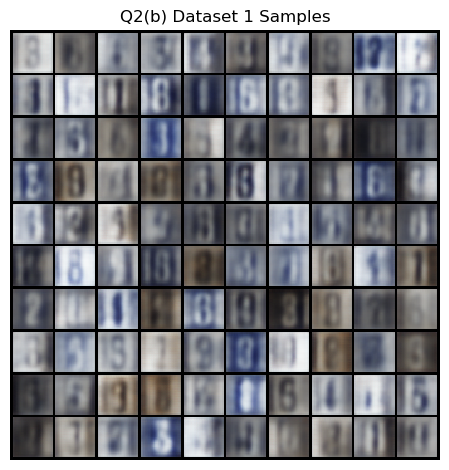

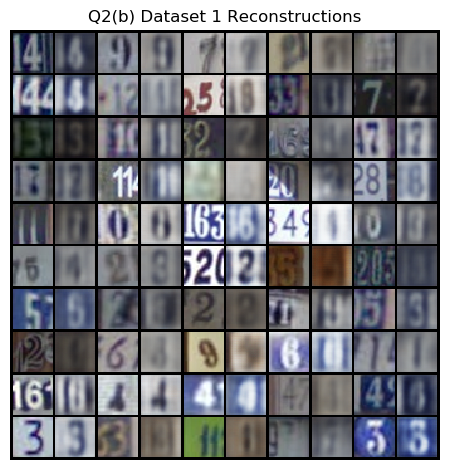

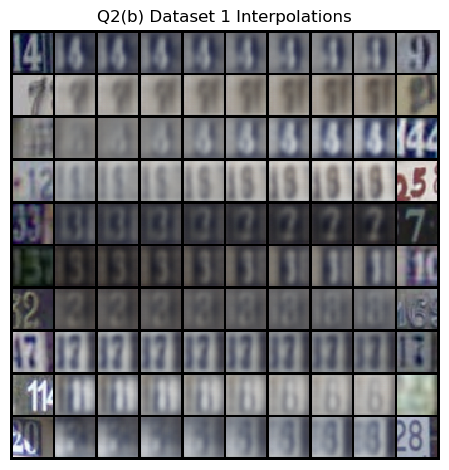

In [40]:
q2_save_results('b', 1, q2_b)

ImageVAEAFPrior(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (encoder_linear): Linear(in_features=4096, out_features=32, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=16, out_features=2048, bias=True)
    (1): ReLU()
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), paddi

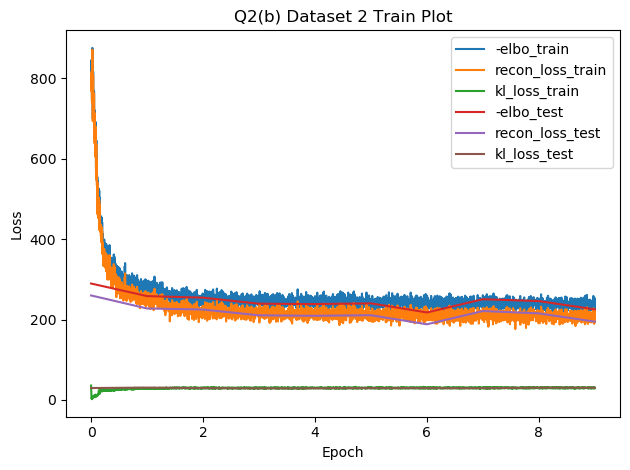

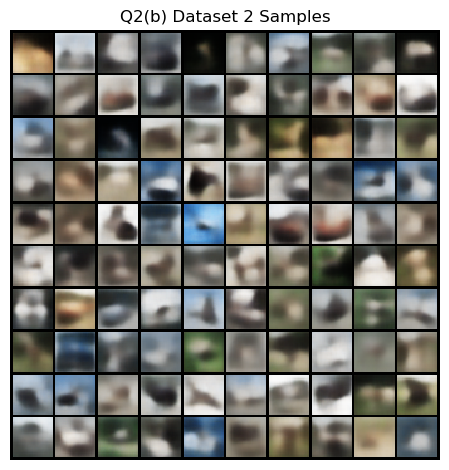

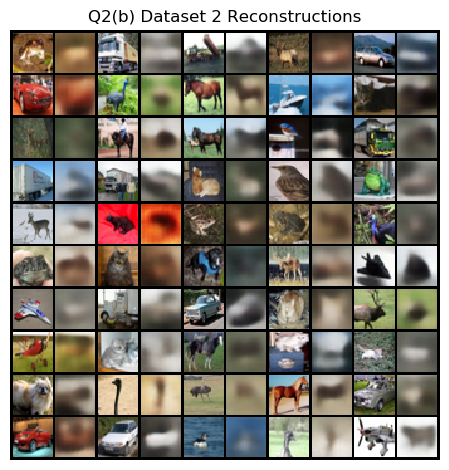

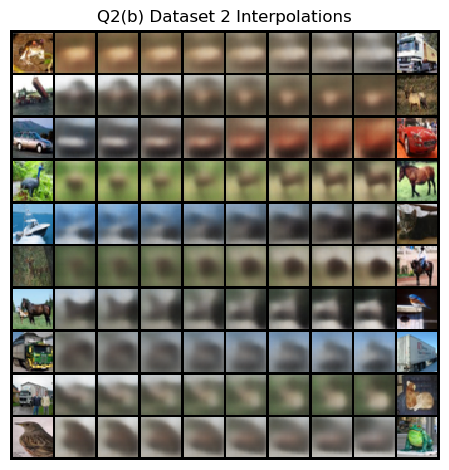

In [41]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [3]:
import torch
from torch.nn import functional as F
class PixelCNN(torch.nn.Module):
    def __init__(self, channel_in, channel_out, vq_vae):
        super().__init__()
        self.vae = vq_vae
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.embedding =torch.nn.Embedding(channel_out, 64)
        self.maskA_block = torch.nn.Sequential(
            MaskedConv2d('A', 64, 64, 7, 1, 3),
            LayerNorm(64),
            torch.nn.ReLU()
        )

        self.maskB_block = torch.nn.Sequential(*[MaskedConv2d('B', 64, 64, 7, 1, 3),
                                                 LayerNorm(64),
                                                 torch.nn.ReLU()] * 4)

        self.one_one_conv = torch.nn.Sequential(
            MaskedConv2d('B', 64, 128, 1, 1, 0),
            LayerNorm(128),
            torch.nn.ReLU(),
            MaskedConv2d('B', 128, channel_out, 1, 1, 0),
        )
        self.criteria =torch.nn.CrossEntropyLoss()
        self.latent_num = channel_out

    def forward(self, x):
        x = x.to(self.device).float()
        self.vae.eval()
        with torch.no_grad():
            zq_index = self.vae(x)[-2]
        outs = self.embedding(zq_index).permute(0, 3, 1, 2)
        outs = self.maskA_block(outs)
        outs = self.maskB_block(outs)
        outs = self.one_one_conv(outs)
        return self.criteria(outs, zq_index)

    def loss(self, x):
        return self(x)

    def sample(self):
        self.vae.eval()
        self.eval()
        with torch.no_grad():
            zq_index = torch.zeros((100, 8, 8)).to(self.device)
            for j in range(8):
                for k in range(8):
                    outs = self.embedding(zq_index.long()).permute(0, 3, 1, 2)
                    outs = self.maskA_block(outs)
                    outs = self.maskB_block(outs)
                    outs = self.one_one_conv(outs)
                    outs = torch.softmax(outs, dim=1)
                    cate_distr = torch.distributions.Categorical(outs.permute(0, 2, 3, 1).reshape(-1, self.latent_num))
                    zq_index.data[:, j, k] = cate_distr.sample().reshape(outs.shape[0], 8, 8)[:, j, k]

            return self.vae.sample(zq_index).permute(0, 2, 3, 1).cpu().numpy()

    def to_one_hot(self, zq_index_):
        zq_index = torch.flatten(zq_index_)
        zq_index = torch.zeros(size=(zq_index.shape[0], self.latent_num)).to(self.device)
        zq_index.zero_()
        zq_index.scatter_(1, torch.flatten(zq_index_).unsqueeze(1), 1)
        zq_index = zq_index.reshape(shape=list(zq_index_.shape) + [-1, ]).float()
        return zq_index.permute(0, 3, 1, 2).contiguous()

class MaskedConv2d(torch.nn.Conv2d):
    def __init__(self, mask_type, c_in, c_out, k_size, stride, pad):
        """2D Convolution with masked weight for Autoregressive connection"""
        super(MaskedConv2d, self).__init__(
            c_in, c_out, k_size, stride, pad, bias=False)
        assert mask_type in ['A', 'B']
        self.mask_type = mask_type
        ch_out, ch_in, height, width = self.weight.size()

        mask = torch.ones(ch_out, ch_in, height, width)
        mask[:, :, height // 2, width // 2:] = 0
        mask[:, :, height // 2 + 1:, :] = 0
        mask[:, :, height // 2, width // 2] = 1 if self.mask_type == 'B' else 0
        self.register_buffer('mask', mask)

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

class MaskedConv2dBlock(torch.nn.Module):
    def __init__(self, mask_type, c_in, c_out, k_size, stride, pad):
        super().__init__()
        self.mask_conv = torch.nn.Sequential(*[MaskedConv2d(mask_type, c_in, c_out, k_size, stride, pad)] * 2)

    def forward(self, x):
        return self.mask_conv(x) + x

class LayerNorm(torch.nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()
class VQVAE(torch.nn.Module):
    def __init__(self, latents_dim, latents_num):
        super().__init__()
        self.latents_dim = latents_dim
        self.latents_num = latents_num
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder = torch.nn.Sequential(torch.nn.Conv2d(3, latents_dim, 4, 2, 1),
                                     torch.nn.BatchNorm2d(latents_dim),
                                     torch.nn.ReLU(),
                                     torch.nn.Conv2d(latents_dim, latents_dim, 4, 2, 1),
                                     ResidualBlocks(latents_dim),
                                     ResidualBlocks(latents_dim)
                                     )
        self.decoder = torch.nn.Sequential(ResidualBlocks(latents_dim),
                                     ResidualBlocks(latents_dim),
                                     torch.nn.BatchNorm2d(latents_dim),
                                     torch.nn.ReLU(),
                                     torch.nn.ConvTranspose2d(latents_dim, latents_dim, 4, 2, 1),
                                     torch.nn.BatchNorm2d(latents_dim),
                                     torch.nn.ReLU(),
                                     torch.nn.ConvTranspose2d(latents_dim, 3, 4, 2, 1))
        code_book = 2 * (torch.rand(size=(latents_num, latents_dim), requires_grad=True) - 0.5) / latents_num
        self.register_parameter("code_book", torch.nn.Parameter(code_book, requires_grad=True))

    def forward(self, x):
        x = x.to(self.device).permute(0, 3, 1, 2).float()
        batch_size = x.shape[0]
        ze = self.encoder(x)
        ze_repeated = ze.unsqueeze(-1).repeat(1, 1, 1, 1, self.latents_num).permute(0, 2, 3, 4, 1)
        code_book_repeated = self.code_book.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat(batch_size, 8, 8, 1, 1)
        distance = torch.sum((ze_repeated - code_book_repeated) ** 2, dim=-1)
        q_index = torch.argmin(distance, dim=-1)
        zq_with_grad = self.code_book[q_index].permute(0, 3, 1, 2)
        zq = ze + (zq_with_grad - ze).detach()
        outs = self.decoder(zq)
        recon_loss = (x - outs) ** 2
        vq_loss = (ze.detach() - zq_with_grad) ** 2
        commit_loss = (ze - zq_with_grad.detach()) ** 2
        return torch.mean(recon_loss), torch.mean(vq_loss), torch.mean(commit_loss), q_index.long(), outs

    def loss(self, x):
        losses = self(x)
        return torch.mean(losses[0] + losses[1] + losses[2])

    def sample(self, zq_index):
        zq = self.code_book[zq_index.long()].permute(0, 3, 1, 2)
        with torch.no_grad():
            return self.decoder(zq)

    def sample_pairs(self, x):
        x = torch.from_numpy(x).to(self.device)
        with torch.no_grad():
            results = self(x)
            reconstructed_images = results[-1]
        image_list = []
        for i in range(x.shape[0]):
            image_list.extend([x[i].float(), reconstructed_images[i].permute(1, 2, 0)])
        return torch.stack(image_list, dim=0).cpu().numpy()

class ResidualBlocks(torch.nn.Module):
    def __init__(self, kernel_num):
        super().__init__()
        self.kernel_num = kernel_num
        self.net = torch.nn.Sequential(
            torch.nn.BatchNorm2d(kernel_num),
            torch.nn.ReLU(),
            torch.nn.Conv2d(kernel_num, kernel_num, 3, 1, 1),
            torch.nn.BatchNorm2d(kernel_num),
            torch.nn.ReLU(),
            torch.nn.Conv2d(kernel_num, kernel_num, 3, 1, 1))
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x):
        x = x.to(self.device)
        return self.net(x) + x

def vq_train(model, train_loader, optimizer, grad_clip=None):
    model.train()
    train_losses = []
    for x in train_loader:
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        train_losses.append(loss.cpu().item())
    return train_losses

def vq_eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    for x in data_loader:
        with torch.no_grad():
            loss = model.loss(x)
            total_loss += loss.cpu().item() * x.shape[0]
    avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss

def vq_train_epochs(model, train_loader, test_loader, train_args, best_model=None):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = 1e8
    test_losses = [vq_eval_loss(model, test_loader)]
    print(f"initial test loss is {test_losses[0]}")
    train_losses = []
    # test_losses = [0,]
    # train_losses = [0,]
    for epoch in range(epochs):
        train_losses.extend(vq_train(model, train_loader, optimizer, grad_clip))
        test_losses.append(vq_eval_loss(model, test_loader))
        if test_losses[-1] < best_loss:
            best_loss = test_losses[-1]
            best_model.load_state_dict(model.state_dict())
        print(f'Epoch {epoch}, loss {test_losses[-1]:.4f}')
    print(f"best loss is {best_loss}")
    return train_losses, test_losses
     
    
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE test losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of Transformer prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of Transformer prior test losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    batch_size = 128
    lr = .001
    epochs = 10
    num_samples = 100
    num_reconstructions = 50
    k = 128                         # latent variables/categories
    d = 256                         # latent dimension/embedding size
    codebook_shape = [k, d]
    codebook = torch.distributions.uniform.Uniform(-1/k, 1/k).sample(codebook_shape)
    assert(codebook.shape == (k, d))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Normalize pixel values to be between 0,1
    train_data = (train_data / 255 - 0.5) * 2
    test_data = (test_data / 255 - 0.5) * 2

    # Load dataset
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    assert(np.ndim(train_loader.dataset) == 4)
    assert(np.ndim(train_data) == 4)

    # Initialize VQVAE
    model = VQVAE(d, k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(model)

    # Run VQVAE training loop
    vqvae_train_losses, vqvae_test_losses = vq_train_epochs(model, train_loader, test_loader, dict(epochs=epochs, lr=lr), model)
    model.eval()

    # Initialize transformer
    transformer = PixelCNN(64, k, model).to(device)
    print(transformer)

    # Run transformer training loop
    transformer_train_losses, transformer_test_losses = vq_train_epochs(transformer, train_loader, test_loader, dict(epochs=epochs, lr=lr), transformer)
    transformer.eval()

    # Generate real image/reconstructed pairs
    reconstructed_pairs = test_data[0:num_reconstructions]
    reconstructed_pairs = (model.sample_pairs(reconstructed_pairs) + 1) * 255 / 2
    assert(reconstructed_pairs.shape == (100, 32, 32, 3))

    # Generate samples
    samples = np.clip((transformer.sample() + 1) * 255 / 2, 0, 255)
    assert(samples.shape == (100, 32, 32, 3))

    return np.array(vqvae_train_losses), np.array(vqvae_test_losses), np.array(transformer_train_losses), np.array(transformer_test_losses), np.floor(samples), np.floor(reconstructed_pairs)




## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

VQVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ResidualBlocks(
      (net): Sequential(
        (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): ResidualBlocks(
      (net): Sequential(
        (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3)

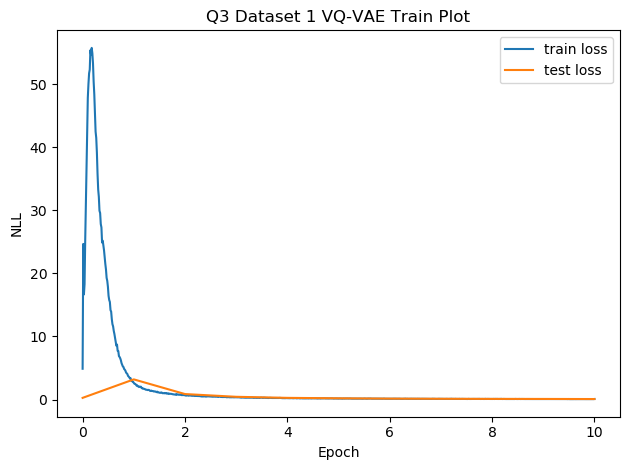

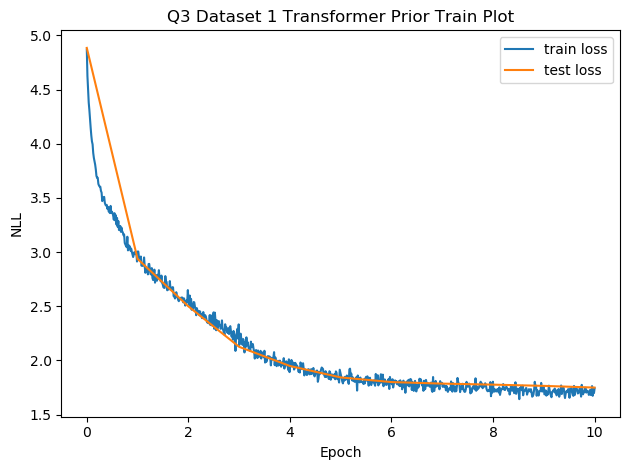

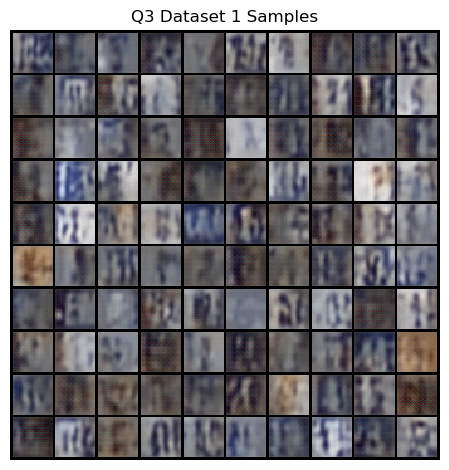

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


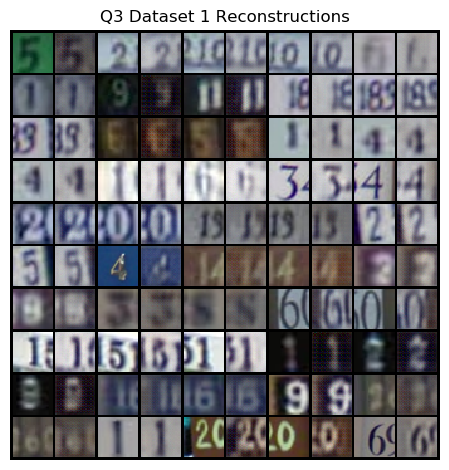

In [6]:
q3_save_results(1, q3)

VQVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ResidualBlocks(
      (net): Sequential(
        (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): ResidualBlocks(
      (net): Sequential(
        (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3)

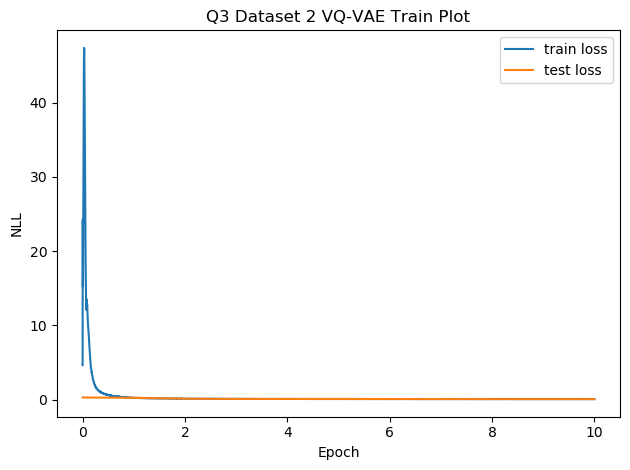

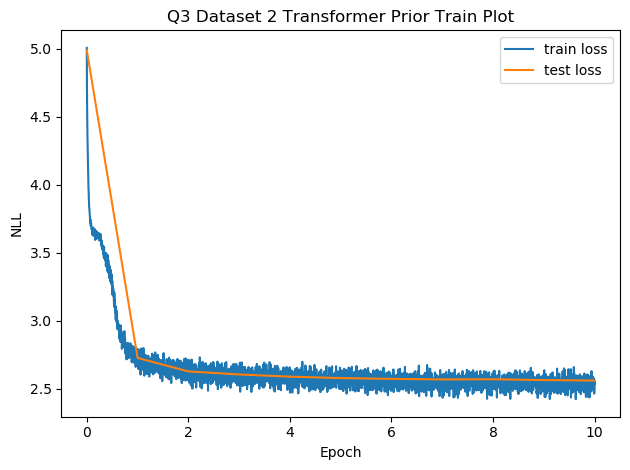

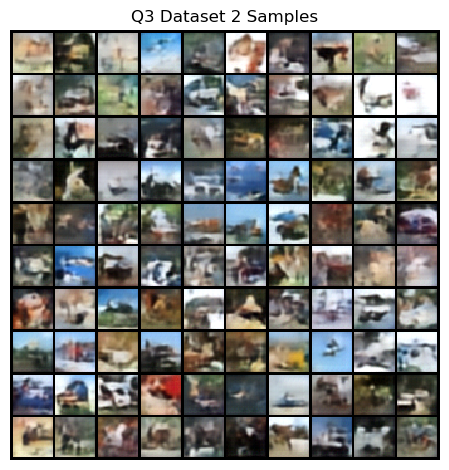

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


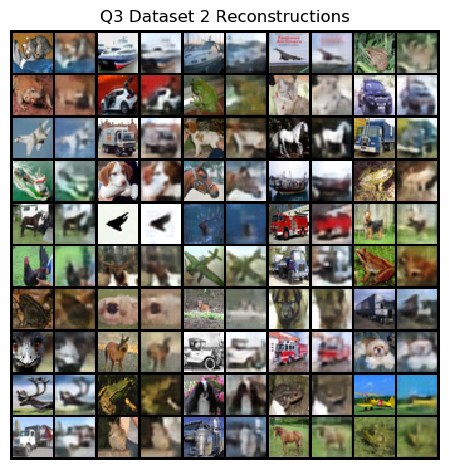

In [7]:
q3_save_results(2, q3)

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)